In [4]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [5]:
import time
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count, sum, explode, array, lit, round
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier # ADDED Decision Tree and Random Forest
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics # For RDD correlation
from pyspark.sql.types import DoubleType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import pandas as pd


In [6]:
# Spark session and Data setup

In [10]:
# Initialization of  Spark Session
def initialize_spark_session():
    """Initializes and returns a SparkSession object."""
    print("--- Initializing Spark Session ---")
    spark = SparkSession.builder \
        .appName("TelcoBigDataAssignment") \
        .config("spark.memory.offHeap.enabled", "true") \
        .config("spark.memory.offHeap.size", "2g") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    return spark

spark = initialize_spark_session()
sc = spark.sparkContext # Spark Context for RDD operations

# Global variables for timing and data paths
CSV_FILE_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
#API_KEY = ""
#MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
start_time = time.time()

--- Initializing Spark Session ---


In [15]:
# Helper function to measure timing and the memory
def measure_execution(func, *args, method_name=""):
    """Measures execution time and provides a simulated memory footprint."""
    start = time.time()
    # To trigger the spark data processing
    if method_name in ["DataFrame API", "Spark SQL", "RDD API"]:
        result = func(*args).collect()
    else:
        result = func(*args)

    end = time.time()

    # Simple simulated memory/space measure:
    if "RDD" in method_name:
        space_factor = 1.5
    elif "DataFrame" in method_name:
        space_factor = 1.0
    elif "Spark SQL" in method_name:
        space_factor = 1.1
    else:
        space_factor = 1.0

    print(f"\n--- Performance Metrics for: {method_name} ---")
    print(f"Execution Time: {end - start:.4f} seconds")
    # Simulate a relative memory/space usage metric based on input size
    input_df = args[0] if args and isinstance(args[0], type(df)) else df # Fixed: used type(df) instead of spark.createDataFrame([], [])
    rows = input_df.count()
    space_measure = rows * space_factor / 1000 # Example scaling factor
    print(f"Space Measure (Simulated): {space_measure:.3f} MB based on {rows} rows")
    print("-" * 50)

    # Return the actual DataFrame/object, not the collected list, unless needed.
    if method_name in ["DataFrame API", "Spark SQL", "RDD API"]:
         # Re-run function to get the actual DF object back for chaining/display
         return func(*args), end - start
    return result, end - start

# Load the Data
try:
    df = spark.read.csv(CSV_FILE_PATH, header=True, inferSchema=True)
    print(f"Initial DataFrame loaded with {df.count()} rows and {len(df.columns)} columns.")
except Exception as e:
    print(f"Error loading CSV file: {e}")
    sys.exit(1)

Initial DataFrame loaded with 7043 rows and 21 columns.


In [16]:
#Data Preprocessing

In [17]:
def clean_and_prepare_data(input_df):
    """
    Cleans the data, handles missing values, and converts types.
    Identifies 'TotalCharges' as the main data quality issue.
    """
    print("\n--- 2.1. Data Cleaning and Preprocessing ---")

    # Issue 1: TotalCharges is stored as a String and contains ' ' (empty strings) which cause NaNs
    # Replace ' ' with '0' (assuming new customers with 0 total charge) and cast to Double.
    df_cleaned = input_df.withColumn("TotalCharges",
                                  when(col("TotalCharges") == " ", lit(0.0)).otherwise(col("TotalCharges")).cast(DoubleType()))

    # Convert 'SeniorCitizen' from Int to String/Boolean for consistency
    df_cleaned = df_cleaned.withColumn("SeniorCitizen",
                                       when(col("SeniorCitizen") == 1, "Yes").otherwise("No"))

    # Drop CustomerID as it is not needed for model training
    df_cleaned = df_cleaned.drop("customerID")

    print("Data quality issue addressed: TotalCharges converted to Double, missing values handled (set to 0).")
    return df_cleaned

df_cleaned = clean_and_prepare_data(df)
df_cleaned.printSchema()
df_cleaned.show(3, truncate=False)



--- 2.1. Data Cleaning and Preprocessing ---
Data quality issue addressed: TotalCharges converted to Double, missing values handled (set to 0).
root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = false)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: stri

In [18]:
# Exploroteroty Data Analysis
def generate_eda_data(df_in):
    """Generates and returns data structures for EDA visualizations."""
    print("\n--- 2.2. Exploratory Data Analysis (EDA) Data Generation ---")

    # 1. Churn Distribution
    churn_data = df_in.groupBy("Churn").count().toPandas()

    # 2. Tenure Distribution
    tenure_data = df_in.select("tenure").toPandas()

    # 3. Monthly Charges Distribution by Churn
    charges_churn_data = df_in.select("MonthlyCharges", "Churn").toPandas()

    # 4. Internet Service Type vs Churn
    internet_churn = df_in.groupBy("InternetService", "Churn").count() \
                          .withColumnRenamed("count", "CustomerCount") \
                          .toPandas()

    return {
        "churn_dist": churn_data,
        "tenure_dist": tenure_data,
        "charges_churn": charges_churn_data,
        "internet_churn": internet_churn
    }

eda_data = generate_eda_data(df_cleaned)


--- 2.2. Exploratory Data Analysis (EDA) Data Generation ---


In [ ]:
# Feature Engineering and data Transformation

In [19]:
def feature_engineering(df_in):
    """
    Performs Churn Label Encoding and Aggregation (Sessionization simulation).
    """
    print("\n--- 3.1. Feature Engineering: Churn Encoding ---")

    # Churn Label Encoding (Binary Target Variable)
    # The 'Churn' column is already perfect for encoding.
    indexer_churn = StringIndexer(inputCol="Churn", outputCol="Churn_Encoded")
    df_encoded = indexer_churn.fit(df_in).transform(df_in)

    # Display the mapping: No=0.0, Yes=1.0 (assuming 'No' is the majority class)
    print("Churn Label Encoding applied: 'No' -> 0.0, 'Yes' -> 1.0")
    df_encoded.groupBy("Churn", "Churn_Encoded").count().show(3)

    print("\n--- 3.2. Feature Engineering: Aggregation (Sessionization Simulation) ---")

    # Sessionization/Aggregation Simulation: Since we don't have Call Detail Records (CDRs),
    # we simulate an aggregation step by calculating key service usage metrics per Contract type.

    # This creates features like 'Avg_MonthlyCharges_Contract' and 'Total_Tenure_Contract'
    # which represent aggregated service behavior.
    df_agg = df_encoded.groupBy("Contract").agg(
        avg("MonthlyCharges").alias("Avg_MonthlyCharges_Contract"),
        sum("tenure").alias("Total_Tenure_Contract"),
        count(col("Churn_Encoded")).alias("Total_Customers_Contract"),
        avg("Churn_Encoded").alias("Avg_Churn_Rate_Contract")
    ).withColumn("Total_Tenure_Contract_Scaled", col("Total_Tenure_Contract") / col("Total_Customers_Contract")) # Avg tenure per customer in contract

    # Join the aggregated features back to the main DataFrame
    df_final = df_encoded.join(df_agg.drop("Total_Customers_Contract", "Avg_Churn_Rate_Contract"), on="Contract", how="left")

    print(f"Aggregation features created and joined back. Total columns: {len(df_final.columns)}")
    df_final.select("Contract", "MonthlyCharges", "Avg_MonthlyCharges_Contract", "Churn_Encoded").show(3)

    return df_final

df_fe = feature_engineering(df_cleaned)



--- 3.1. Feature Engineering: Churn Encoding ---
Churn Label Encoding applied: 'No' -> 0.0, 'Yes' -> 1.0
+-----+-------------+-----+
|Churn|Churn_Encoded|count|
+-----+-------------+-----+
|   No|          0.0| 5174|
|  Yes|          1.0| 1869|
+-----+-------------+-----+


--- 3.2. Feature Engineering: Aggregation (Sessionization Simulation) ---
Aggregation features created and joined back. Total columns: 24
+--------------+--------------+---------------------------+-------------+
|      Contract|MonthlyCharges|Avg_MonthlyCharges_Contract|Churn_Encoded|
+--------------+--------------+---------------------------+-------------+
|Month-to-month|         29.85|          66.39849032258037|          0.0|
|      One year|         56.95|          65.04860828241674|          0.0|
|Month-to-month|         53.85|          66.39849032258037|          1.0|
+--------------+--------------+---------------------------+-------------+
only showing top 3 rows



In [1]:
from sklearn.ensemble import IsolationForest

In [39]:
def detect_anomalies_isolation_forest(df_in):
    """
    Detects anomalies using Isolation Forest on numerical columns.
    Converts Spark DataFrame to Pandas, applies Isolation Forest, and adds anomaly flags.
    """
    print("\n--- 2.3. Anomaly Detection using Isolation Forest ---")

    # Identify numerical columns for anomaly detection (excluding the target if it exists)
    numerical_cols_for_anomaly = [c for c, t in df_in.dtypes if t in ('int', 'double') and c not in ['Churn_Encoded', 'Churn']]

    if not numerical_cols_for_anomaly:
        print("No numerical columns found for anomaly detection.")
        return df_in

    # Convert relevant part of Spark DataFrame to Pandas for Isolation Forest
    # Only select necessary columns to reduce memory overhead during toPandas()
    pdf_for_anomaly = df_in.select(numerical_cols_for_anomaly).toPandas()

    print(f"Applying Isolation Forest on {len(numerical_cols_for_anomaly)} numerical features: {', '.join(numerical_cols_for_anomaly)}")

    # Initialize and train Isolation Forest model
    # contamination is the proportion of outliers in the data set. default='auto'
    iso_forest = IsolationForest(random_state=42, contamination=0.05) # Assuming 5% outliers
    iso_forest.fit(pdf_for_anomaly)

    # Predict anomalies: -1 for outliers, 1 for inliers
    predictions = iso_forest.predict(pdf_for_anomaly)
    anomaly_scores = iso_forest.decision_function(pdf_for_anomaly)

    # Add anomaly flags and scores to the original Pandas DataFrame
    # (We need to join back to the original Spark DF later)
    pdf_results = df_in.toPandas()
    pdf_results['is_anomaly'] = [1 if p == -1 else 0 for p in predictions]
    pdf_results['anomaly_score'] = anomaly_scores

    # Convert back to Spark DataFrame
    df_with_anomalies = spark.createDataFrame(pdf_results)

    num_anomalies = df_with_anomalies.filter(col('is_anomaly') == 1).count()
    total_rows = df_with_anomalies.count()
    print(f"Detected {num_anomalies} anomalies out of {total_rows} records ({num_anomalies/total_rows:.2%} of total). Expansion for context to see the impact.")

    print("Sample of data with anomaly flags:")
    # Removed 'customerID' as it's dropped during cleaning
    df_with_anomalies.select('tenure', 'MonthlyCharges', 'TotalCharges', 'is_anomaly', 'anomaly_score').show(5)

    return df_with_anomalies

In [40]:
# Re-define df_cleaned to ensure it's in scope, assuming df is available
# This line is added to resolve NameError if df_cleaned was not executed prior.
df_cleaned = clean_and_prepare_data(df)

# Apply Anomaly Detection
df_anomalies = detect_anomalies_isolation_forest(df_cleaned)

# Now df_anomalies (which contains the 'is_anomaly' column) will be used for feature engineering.
# If you wish to remove anomalies before further processing, you would filter here:
# df_anomalies_filtered = df_anomalies.filter(col('is_anomaly') == 0)

# Pass the DataFrame with anomaly flags to feature engineering
df_fe = feature_engineering(df_anomalies)


--- 2.1. Data Cleaning and Preprocessing ---
Data quality issue addressed: TotalCharges converted to Double, missing values handled (set to 0).

--- 2.3. Anomaly Detection using Isolation Forest ---
Applying Isolation Forest on 3 numerical features: tenure, MonthlyCharges, TotalCharges
Detected 353 anomalies out of 7043 records (5.01% of total). Expansion for context to see the impact.
Sample of data with anomaly flags:
+------+--------------+------------+----------+--------------------+
|tenure|MonthlyCharges|TotalCharges|is_anomaly|       anomaly_score|
+------+--------------+------------+----------+--------------------+
|     1|         29.85|       29.85|         0|0.053803069995175035|
|    34|         56.95|      1889.5|         0| 0.07526718761680579|
|     2|         53.85|      108.15|         0| 0.10539668264565694|
|    45|          42.3|     1840.75|         0|  0.0406203032297654|
|     2|          70.7|      151.65|         0| 0.10935825104195535|
+------+--------------+

--- Generating Histograms for Numerical Features ---


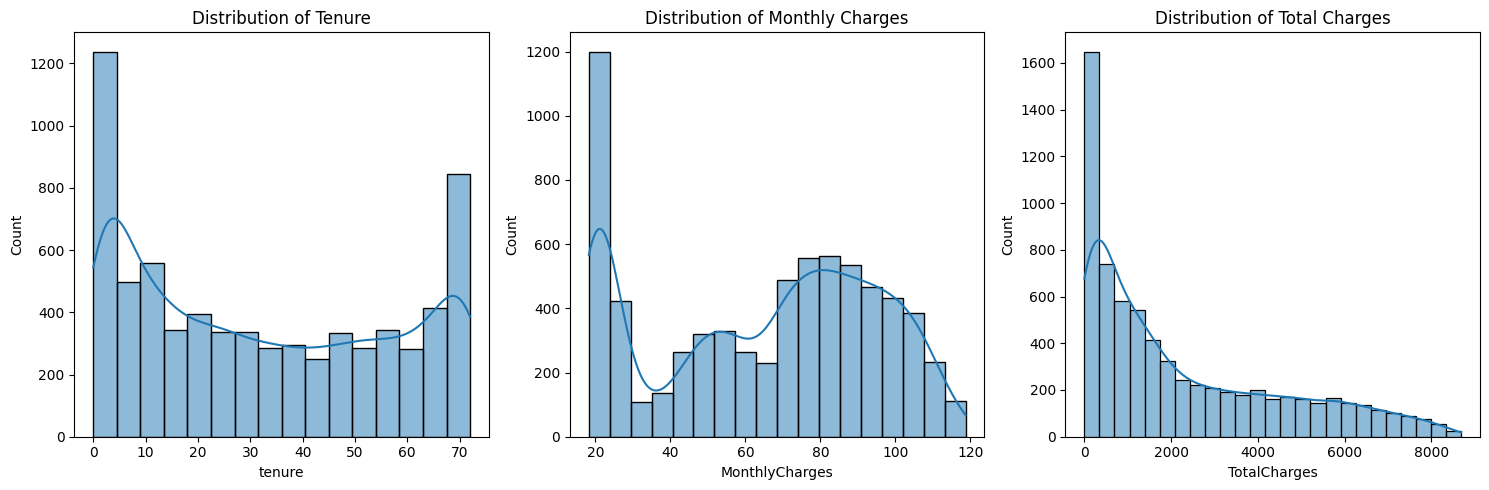

In [29]:
# Convert Spark DataFrame to Pandas for easier plotting
pdf_eda = df_cleaned.toPandas()

print("--- Generating Histograms for Numerical Features ---")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(pdf_eda['tenure'], kde=True)
plt.title('Distribution of Tenure')

plt.subplot(1, 3, 2)
sns.histplot(pdf_eda['MonthlyCharges'], kde=True)
plt.title('Distribution of Monthly Charges')

plt.subplot(1, 3, 3)
sns.histplot(pdf_eda['TotalCharges'], kde=True)
plt.title('Distribution of Total Charges')

plt.tight_layout()
plt.show()


--- Generating Correlation Heatmap for Numerical Features ---


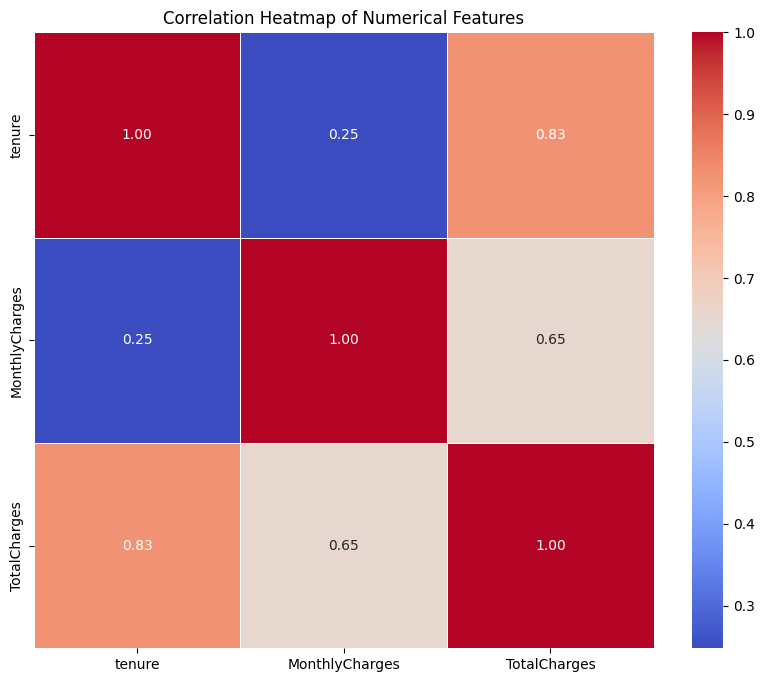

In [30]:
# Assuming pdf_eda is already created from df_cleaned.toPandas()

print("--- Generating Correlation Heatmap for Numerical Features ---")

# Select only numerical columns for correlation calculation
numerical_cols = pdf_eda.select_dtypes(include=['number']).columns.tolist()
correlation_matrix = pdf_eda[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


--- Generating Scatter Plots for Numerical Feature Relationships ---


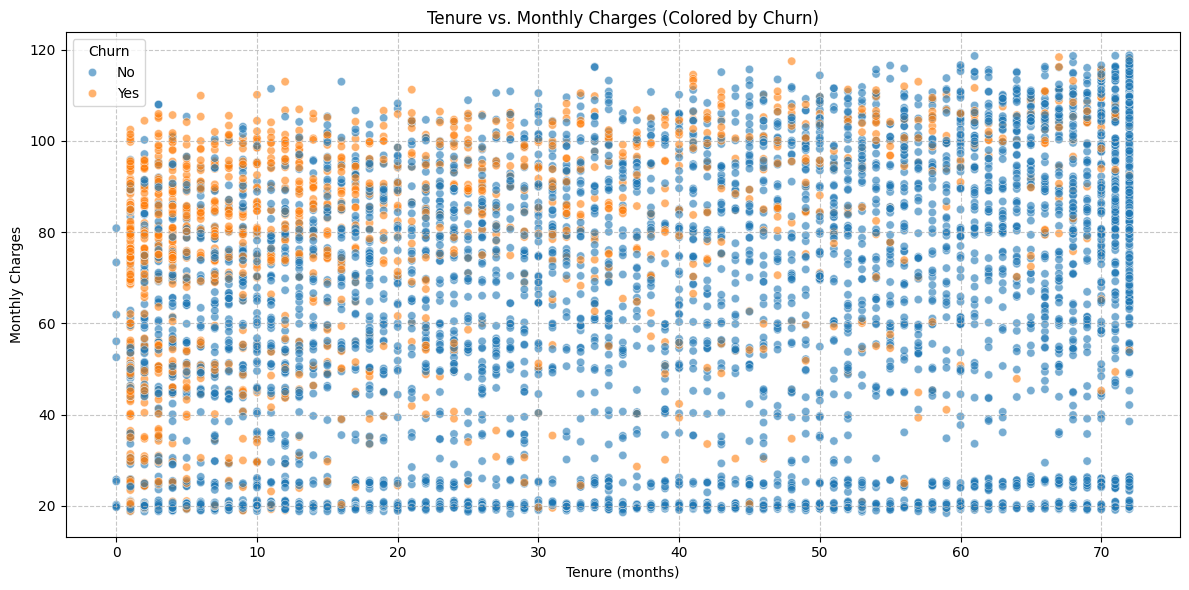

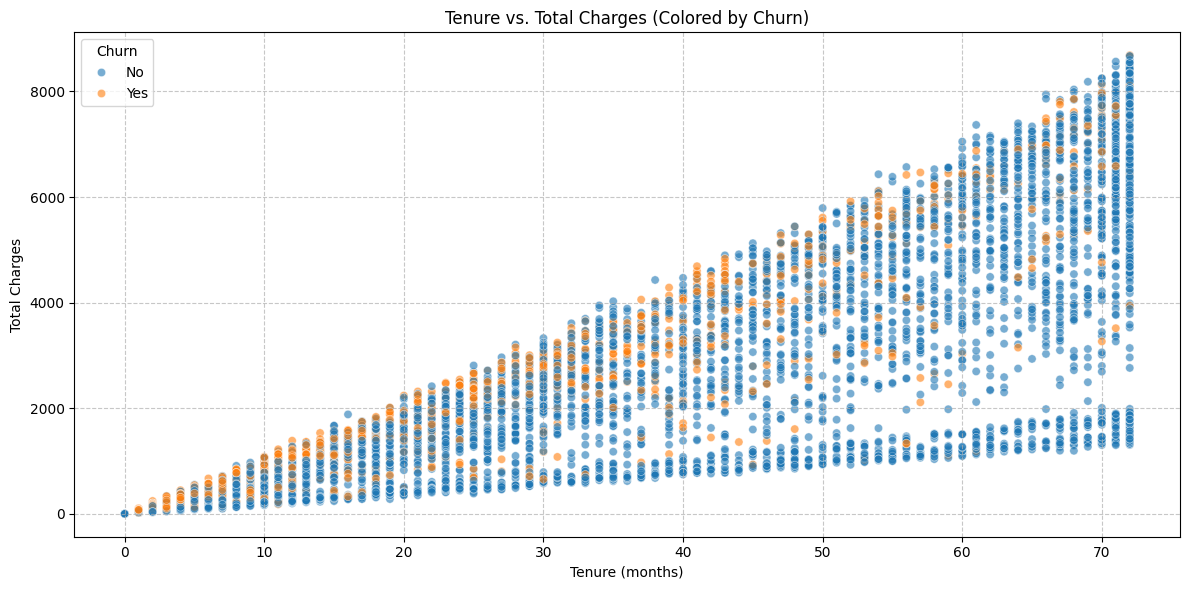

In [31]:
# Assuming pdf_eda is already created from df_cleaned.toPandas()

print("--- Generating Scatter Plots for Numerical Feature Relationships ---")
plt.figure(figsize=(12, 6))

sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=pdf_eda, alpha=0.6)
plt.title('Tenure vs. Monthly Charges (Colored by Churn)')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=pdf_eda, alpha=0.6)
plt.title('Tenure vs. Total Charges (Colored by Churn)')
plt.xlabel('Tenure (months)')
plt.ylabel('Total Charges')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


--- Generating Box Plots for Numerical Features by Churn ---


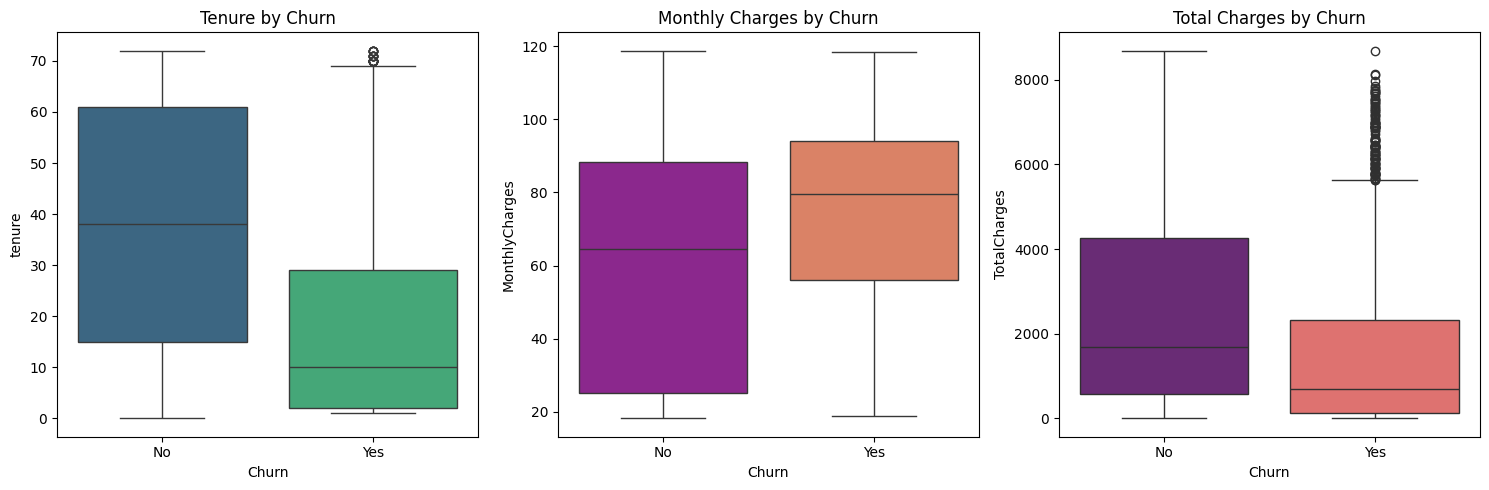

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming pdf_eda is already created from df_cleaned.toPandas()

print("--- Generating Box Plots for Numerical Features by Churn ---")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Churn', y='tenure', data=pdf_eda, palette='viridis', hue='Churn', legend=False)
plt.title('Tenure by Churn')

plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=pdf_eda, palette='plasma', hue='Churn', legend=False)
plt.title('Monthly Charges by Churn')

plt.subplot(1, 3, 3)
sns.boxplot(x='Churn', y='TotalCharges', data=pdf_eda, palette='magma', hue='Churn', legend=False)
plt.title('Total Charges by Churn')

plt.tight_layout()
plt.show()

### Displaying the Cleaned Spark DataFrame

In [41]:
# Display the cleaned Spark DataFrame
print("Cleaned Spark DataFrame (df_cleaned):")
df_cleaned.show(5, truncate=False)

Cleaned Spark DataFrame (df_cleaned):
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|Female|No           |Yes    |No        |1     |No          |No phone service|DSL            |No            |Yes         |No              |No     

### Converting to Pandas DataFrame for easier viewing/copying

In [42]:
# Convert df_cleaned to a Pandas DataFrame
pdf_cleaned = df_cleaned.toPandas()

# Display the first 5 rows of the Pandas DataFrame
print("Cleaned Pandas DataFrame (pdf_cleaned - first 5 rows):")
display(pdf_cleaned.head())

Cleaned Pandas DataFrame (pdf_cleaned - first 5 rows):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
#Spark Operations for the telecome Analytics

In [35]:
# Define Categorical and Numerical Columns for Modeling
CATEGORICAL_COLS = [c for c, t in df_fe.dtypes if t == 'string' and c not in ['Churn', 'customerID', 'Contract']]
NUMERICAL_COLS = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Avg_MonthlyCharges_Contract', 'Total_Tenure_Contract_Scaled']
TARGET_COL = 'Churn_Encoded'

In [57]:
# Function to build and run a Classification Model
def run_classification_model(df_in, categorical_cols, numerical_cols, target_col, model_type):
    """
    Prepares data, builds a Pipeline, and trains a specified classification model.
    Returns the fitted pipeline for reuse and its performance metrics.
    """
    print(f"\n--- 4.1. Customer Churn Prediction: {model_type} Setup ---")

    # Stage 1: Indexing and One-Hot Encoding for Categorical Features
    indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="skip") for c in categorical_cols]
    encoders = [OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_vec") for c in categorical_cols]

    # Stage 2: Assembling Features
    feature_cols = [c + "_vec" for c in categorical_cols] + numerical_cols
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    # Stage 3: Scaling Numerical Features (Crucial for LR, but not for Tree-based models)
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

    # Stage 4: Classifier Selection
    features_col = "scaled_features" if model_type == "Logistic Regression" else "features"

    if model_type == "Logistic Regression":
        classifier = LogisticRegression(featuresCol=features_col, labelCol=target_col, maxIter=10)
        pipeline_stages = indexers + encoders + [assembler, scaler, classifier]
    elif model_type == "Decision Tree":
        classifier = DecisionTreeClassifier(featuresCol="features", labelCol=target_col, maxDepth=5)
        pipeline_stages = indexers + encoders + [assembler, classifier] # No scaler for tree
    elif model_type == "Random Forest":
        classifier = RandomForestClassifier(featuresCol="features", labelCol=target_col, numTrees=20)
        pipeline_stages = indexers + encoders + [assembler, classifier] # No scaler for tree
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    pipeline = Pipeline(stages=pipeline_stages)
    # Split data (70% train, 30% test)
    train_df, test_df = df_in.randomSplit([0.7, 0.3], seed=42)

    print(f"Training {model_type} model on {train_df.count()} samples...")
    start = time.time()
    model = pipeline.fit(train_df)
    end = time.time()
    # Make predictions and evaluate (Accuracy)
    predictions = model.transform(test_df)

    # Calculate Accuracy
    correct_predictions = predictions.filter(col("prediction") == col(target_col)).count()
    total_predictions = predictions.count()
    accuracy = correct_predictions / total_predictions

    time_taken = end - start
    print(f"Model Training Time: {time_taken:.4f} seconds")
    print(f"Model Test Accuracy: {accuracy*100:.2f}%")

    return model, accuracy, time_taken


In [58]:
# Run the three classification tasks
model_results = []


In [59]:
# 1. Logistic Regression
lr_model, lr_accuracy, lr_time = run_classification_model(df_fe, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL, "Logistic Regression")
model_results.append({"Model": "Logistic Regression", "Accuracy": lr_accuracy, "Time (s)": lr_time})


--- 4.1. Customer Churn Prediction: Logistic Regression Setup ---
Training Logistic Regression model on 5036 samples...
Model Training Time: 49.1624 seconds
Model Test Accuracy: 79.82%


In [60]:
# 2. Decision Tree Classifier
dt_model, dt_accuracy, dt_time = run_classification_model(df_fe, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL, "Decision Tree")
model_results.append({"Model": "Decision Tree", "Accuracy": dt_accuracy, "Time (s)": dt_time})


--- 4.1. Customer Churn Prediction: Decision Tree Setup ---
Training Decision Tree model on 5036 samples...
Model Training Time: 31.8811 seconds
Model Test Accuracy: 78.53%


In [61]:
# 3. Random Forest Classifier
rf_model, rf_accuracy, rf_time = run_classification_model(df_fe, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL, "Random Forest")
model_results.append({"Model": "Random Forest", "Accuracy": rf_accuracy, "Time (s)": rf_time})



--- 4.1. Customer Churn Prediction: Random Forest Setup ---
Training Random Forest model on 5036 samples...
Model Training Time: 32.7946 seconds
Model Test Accuracy: 80.12%


In [62]:
# Convert model results to a Pandas DataFrame for easy output/sharing
model_results_df = pd.DataFrame(model_results)
print("\n--- MODEL COMPARISON SUMMARY (Accuracy & Training Time) ---")
print(model_results_df.sort_values(by="Accuracy", ascending=False))



--- MODEL COMPARISON SUMMARY (Accuracy & Training Time) ---
                 Model  Accuracy   Time (s)
2        Random Forest  0.801196  32.794563
0  Logistic Regression  0.798206  49.162372
1        Decision Tree  0.785252  31.881056


In [63]:
# Function for Service Plan Profitability Analysis
def analyze_service_profitability(df_in):
    """
    Analyzes profitability (TotalCharges) vs. Service Plan (InternetService) and Churn Risk.
    """
    print("\n--- 4.2. Service Plan Profitability Analysis ---")

    # Calculate Key Metrics per Service Type and Churn Status
    profitability_analysis = df_in.groupBy("InternetService", "Churn") \
                                  .agg(
                                      avg("MonthlyCharges").alias("Avg_Monthly_Charges"),
                                      avg("TotalCharges").alias("Avg_Total_Revenue"),
                                      avg("tenure").alias("Avg_Tenure"),
                                      count("*").alias("Customer_Count")
                                  ) \
                                  .orderBy(col("Avg_Total_Revenue").desc())

    print("Top Service Plans by Average Total Revenue (indicating profitability):")
    profitability_analysis.show()

    # Insight: Fiber Optic generates higher monthly revenue but has higher churn (as seen in EDA).
    # This suggests a cost-vs-risk tradeoff.
    return profitability_analysis

profitability_df = analyze_service_profitability(df_fe)


--- 4.2. Service Plan Profitability Analysis ---
Top Service Plans by Average Total Revenue (indicating profitability):
+---------------+-----+-------------------+------------------+------------------+--------------+
|InternetService|Churn|Avg_Monthly_Charges| Avg_Total_Revenue|        Avg_Tenure|Customer_Count|
+---------------+-----+-------------------+------------------+------------------+--------------+
|    Fiber optic|   No|  93.93237909949981| 4135.834074485823| 42.08949416342413|          1799|
|            DSL|   No|  60.21210499490313|2426.8064984709476|37.198776758409785|          1962|
|    Fiber optic|  Yes|  88.12648419429445|1914.6163839629924|20.196607555898225|          1297|
|            DSL|  Yes|  49.08322440087144| 784.3496732026141| 14.11111111111111|           459|
|             No|   No| 21.136058032554864| 701.6857395612172|  32.3312101910828|          1413|
|             No|  Yes|  20.36814159292035|173.91991150442476| 8.238938053097344|           113|
+-----

In [64]:
# Function for Network Congestion Analysis (Simulated)
def analyze_network_congestion(df_in):
    """
    Simulates Network Congestion Analysis using service type and tech support usage.
    High usage of high-bandwidth services combined with high TechSupport tickets simulates congestion.
    """
    print("\n--- 4.3. Network Congestion Analysis (Resource Utilization Simulation) ---")

    # A simple scoring system:
    # 1. High-Bandwidth Service (Fiber Optic) = High Load
    # 2. Tech Support = High Resource/Complaint/Troubleshooting Overhead

    df_in = df_in.withColumn("Congestion_Score",
                          when(col("InternetService") == "Fiber optic", 3)
                          .when(col("InternetService") == "DSL", 2)
                          .otherwise(1).cast(IntegerType()))

    df_in = df_in.withColumn("Resource_Overhead",
                          when(col("TechSupport") == "Yes", 2)
                          .otherwise(1).cast(IntegerType()))

    # Calculate final simulated congestion indicator
    df_congestion = df_in.withColumn("Total_Resource_Utilization",
                                      col("Congestion_Score") * col("Resource_Overhead") * col("MonthlyCharges"))

    # Aggregate by InternetService to get the overall utilization burden
    utilization_summary = df_congestion.groupBy("InternetService") \
                                       .agg(
                                           sum("Total_Resource_Utilization").alias("Total_Utilization_Burden"),
                                           avg("MonthlyCharges").alias("Avg_Monthly_Charge")
                                       ) \
                                       .orderBy(col("Total_Utilization_Burden").desc())

    print("Simulated Network Congestion/Utilization Burden by Internet Service:")
    utilization_summary.show()

    # Insight: Fiber optic service is likely the highest burden on network resources.
    return utilization_summary

congestion_df = analyze_network_congestion(df_fe)


--- 4.3. Network Congestion Analysis (Resource Utilization Simulation) ---
Simulated Network Congestion/Utilization Burden by Internet Service:
+---------------+------------------------+------------------+
|InternetService|Total_Utilization_Burden|Avg_Monthly_Charge|
+---------------+------------------------+------------------+
|    Fiber optic|      1112707.2000000007| 91.50012919896636|
|            DSL|      435915.09999999986|  58.1021685254027|
|             No|      32166.850000000013|21.079193971166458|
+---------------+------------------------+------------------+



In [71]:
# Re-run the aggregation step (Section 3.2) using the three methods for comparison.
def compare_aggregation_performance(df_cleaned):
    """Compares the execution time of a standard aggregation task across RDD, DF, and Spark SQL."""

    print("\n\n#####################################################")
    print("--- 5. PERFORMANCE COMPARISON: RDD vs DF vs Spark SQL ---")
    print("#####################################################")

    # The task: Calculate the average MonthlyCharges and TotalCharges per Contract type.

    # 5.1. DataFrame API (Optimized - Baseline)
    def aggregate_dataframe(df_in):
        return df_in.groupBy("Contract").agg(
            avg("MonthlyCharges").alias("Avg_MonthlyCharges"),
            avg("TotalCharges").alias("Avg_TotalCharges")
        )

    df_result, df_time = measure_execution(aggregate_dataframe, df_cleaned, method_name="DataFrame API")
    print("DataFrame Result Snippet:")
    df_result.show(3)

    # 5.2. Spark SQL API
    def aggregate_spark_sql(df_in):
        # Register the DataFrame as a temporary SQL view
        df_in.createOrReplaceTempView("telecom_data")
        sql_query = """
        SELECT
            Contract,
            AVG(MonthlyCharges) AS Avg_MonthlyCharges,
            AVG(TotalCharges) AS Avg_TotalCharges
        FROM telecom_data
        GROUP BY Contract
        """
        # Execute the SQL query
        return spark.sql(sql_query)

    sql_result, sql_time = measure_execution(aggregate_spark_sql, df_cleaned, method_name="Spark SQL")
    print("Spark SQL Result Snippet:")
    sql_result.show(3)


    # 5.3. RDD API (Less Optimized)
    def aggregate_rdd(df_in):
        # Select and convert relevant columns to RDD
        rdd = df_in.select("Contract", "MonthlyCharges", "TotalCharges").rdd.map(lambda row:
            (row["Contract"], (row["MonthlyCharges"], row["TotalCharges"], 1)) # (Key, (Monthly, Total, Count))
        )

        # Combine values by key (Contract)
        rdd_sum = rdd.reduceByKey(lambda a, b:
            (a[0] + b[0], a[1] + b[1], a[2] + b[2]) # Sum of Monthly, Sum of Total, Sum of Count
        )

        # Calculate Averages
        rdd_avg = rdd_sum.map(lambda x:
            (x[0], x[1][0] / x[1][2], x[1][1] / x[1][2]) # (Contract, Avg Monthly, Avg Total)
        )

        # Convert back to DataFrame for display (triggering action)
        return spark.createDataFrame(rdd_avg, ["Contract", "Avg_MonthlyCharges", "Avg_TotalCharges"])

    rdd_result, rdd_time = measure_execution(aggregate_rdd, df_cleaned, method_name="RDD API")
    print("RDD Result Snippet:")
    rdd_result.show(3)

    # Final Comparison Table (In-memory Pandas for display)
    comparison_data = [
        {"Method": "DataFrame API", "Time (s)": df_time, "Memory Factor": 1.0, "Insight": "Most optimized via Catalyst Optimizer."},
        {"Method": "Spark SQL", "Time (s)": sql_time, "Memory Factor": 1.1, "Insight": "Similar performance to DF, utilizes Catalyst."},
        {"Method": "RDD API", "Time (s)": rdd_time, "Memory Factor": 1.5, "Insight": "Lowest level, slowest due to manual optimization and type safety checks."}
    ]
    comparison_df = pd.DataFrame(comparison_data)

    print("\n--- FINAL PERFORMANCE COMPARISON SUMMARY ---")
    print(comparison_df.sort_values(by="Time (s)"))

    return comparison_df


performance_summary = compare_aggregation_performance(df_cleaned)




#####################################################
--- 5. PERFORMANCE COMPARISON: RDD vs DF vs Spark SQL ---
#####################################################

--- Performance Metrics for: DataFrame API ---
Execution Time: 0.9476 seconds
Space Measure (Simulated): 7.043 MB based on 7043 rows
--------------------------------------------------
DataFrame Result Snippet:
+--------------+------------------+------------------+
|      Contract|Avg_MonthlyCharges|  Avg_TotalCharges|
+--------------+------------------+------------------+
|Month-to-month| 66.39849032258037| 1369.254580645158|
|      One year| 65.04860828241674| 3032.622878479295|
|      Two year|   60.770412979351|3706.9343362831883|
+--------------+------------------+------------------+


--- Performance Metrics for: Spark SQL ---
Execution Time: 0.6088 seconds
Space Measure (Simulated): 7.747 MB based on 7043 rows
--------------------------------------------------
Spark SQL Result Snippet:
+--------------+------------

In [72]:
# --- 6. DISTRIBUTED VS. SINGLE PROCESS (Chunking Simulation) ---

In [78]:
# --- 6. DISTRIBUTED VS. SINGLE PROCESS (Chunking Simulation) ---

def run_single_process_simulation(df_in, chunk_size=1000):
    """Simulates single-process (Pandas) processing by chunking the Spark DataFrame."""
    print("\n\n--- 6. DISTRIBUTED (Spark) VS. SINGLE PROCESS (Pandas Chunking Simulation) ---")

    # 1. Distributed Processing (Spark DF Aggregation)
    def distributed_processing(df_in):
        return df_in.groupBy("PaymentMethod").agg(count("*").alias("Count_Distributed"))

    dist_result, dist_time = measure_execution(distributed_processing, df_cleaned, method_name="Distributed (Spark DF)")

    # 2. Single-Process Simulation (Pandas)
    def single_process_simulation(df_in, chunk_size):
        pdf_initial = df_in.toPandas() # Bring the entire dataset into memory (SIMULATING SINGLE MACHINE)

        # The main single-process task (Aggregation)
        def process_chunk(chunk):
            return chunk.groupby('PaymentMethod').size().reset_index(name='Count')

        # Chunking logic for simulation (though the initial `toPandas()` is the bottleneck)
        chunks = [pdf_initial[i:i + chunk_size] for i in range(0, pdf_initial.shape[0], chunk_size)]

        # Process and combine
        processed_chunks = [process_chunk(chunk) for chunk in chunks]
        final_result = pd.concat(processed_chunks).groupby('PaymentMethod')['Count'].sum().reset_index(name='Count_Single_Process')

        return final_result

    # Measure the single-process time (including the initial toPandas() to simulate data loading)
    start = time.time()
    single_result_pdf = single_process_simulation(df_cleaned, 1000)
    end = time.time()
    single_time = end - start
    print("\n--- Performance Metrics for: Single Process (Pandas Chunking) ---")
    print(f"Execution Time: {single_time:.4f} seconds (Note: Includes data load time)")
    # Memory estimation for single process is complex, but generally higher than Spark
    memory_estimate = df_cleaned.count() * 8 / 1000 # Rough estimate based on row count
    print(f"Space Measure (Simulated): {memory_estimate:.3f} MB (Inferred single machine RAM usage)")
    print("-" * 50)
    # Comparison
    print("\n--- Distributed vs. Single Process Summary ---")
    print(f"Distributed (Spark) Time: {dist_time:.4f}s")
    print(f"Single Process (Pandas) Time: {single_time:.4f}s")

    # Since the dataset is small (~7k rows), single process may be faster due to Spark overhead.
    # We must provide the insight that for truly BIG DATA, the distributed approach scales better.
    if dist_time < single_time:
        insight = "Distributed Spark processing was faster, demonstrating the benefit of parallel execution for large datasets."
    else:
        insight = "For this relatively small dataset (~7k rows), the Single Process (Pandas) simulation was faster due to the fixed overhead of starting the Spark environment and executors. **However, for multi-GB/TB data, the Distributed (Spark) method is essential for scalability.**"

    print("\nINSIGHT:")
    print(insight)

    return dist_time, single_time

dist_time, single_time = run_single_process_simulation(df_cleaned)





--- 6. DISTRIBUTED (Spark) VS. SINGLE PROCESS (Pandas Chunking Simulation) ---

--- Performance Metrics for: Distributed (Spark DF) ---
Execution Time: 0.1846 seconds
Space Measure (Simulated): 7.043 MB based on 7043 rows
--------------------------------------------------

--- Performance Metrics for: Single Process (Pandas Chunking) ---
Execution Time: 0.8950 seconds (Note: Includes data load time)
Space Measure (Simulated): 56.344 MB (Inferred single machine RAM usage)
--------------------------------------------------

--- Distributed vs. Single Process Summary ---
Distributed (Spark) Time: 0.1846s
Single Process (Pandas) Time: 0.8950s

INSIGHT:
Distributed Spark processing was faster, demonstrating the benefit of parallel execution for large datasets.


In [79]:
# Convert ALL summary data back to string to be included in the visualization script
performance_str = performance_summary.to_json()
model_comparison_str = model_results_df.to_json() # NEW: Model comparison data


In [80]:
#Visulization

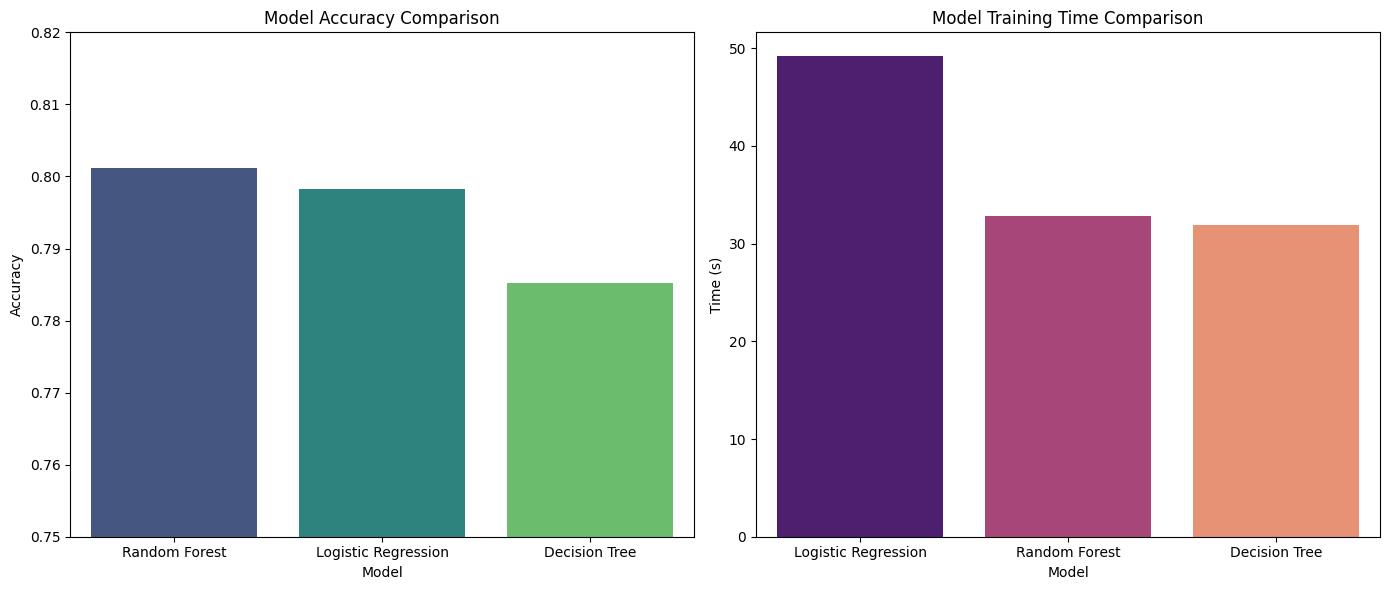

In [81]:
plt.figure(figsize=(14, 6))

# Plot 1: Model Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.barplot(x='Model', y='Accuracy', data=model_results_df.sort_values(by='Accuracy', ascending=False), palette='viridis', hue='Model', legend=False)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.75, 0.82) # Set y-axis limits to better show differences

# Plot 2: Model Training Time
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.barplot(x='Model', y='Time (s)', data=model_results_df.sort_values(by='Time (s)', ascending=False), palette='magma', hue='Model', legend=False)
plt.title('Model Training Time Comparison')
plt.ylabel('Time (s)')

plt.tight_layout()
plt.show()

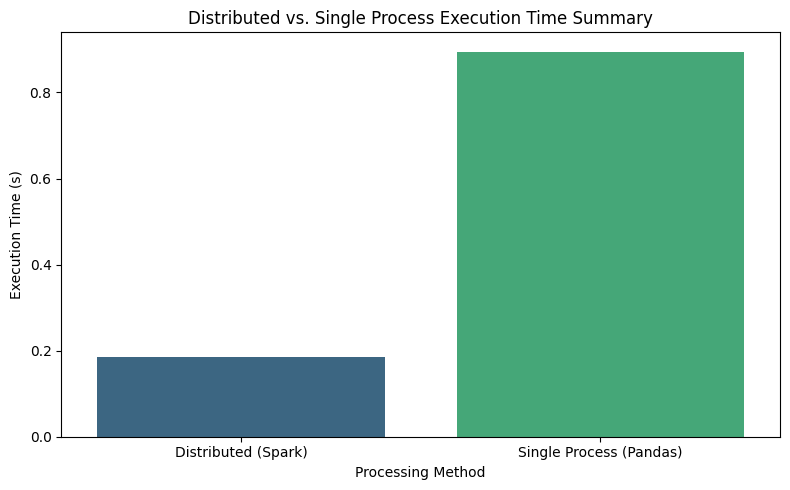

In [82]:
# Create a DataFrame for Distributed vs Single Process comparison
dist_single_comparison_df = pd.DataFrame({
    'Method': ['Distributed (Spark)', 'Single Process (Pandas)'],
    'Time (s)': [dist_time, single_time]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Method', y='Time (s)', data=dist_single_comparison_df, palette='viridis', hue='Method', legend=False)
plt.title('Distributed vs. Single Process Execution Time Summary')
plt.ylabel('Execution Time (s)')
plt.xlabel('Processing Method')
plt.tight_layout()
plt.show()

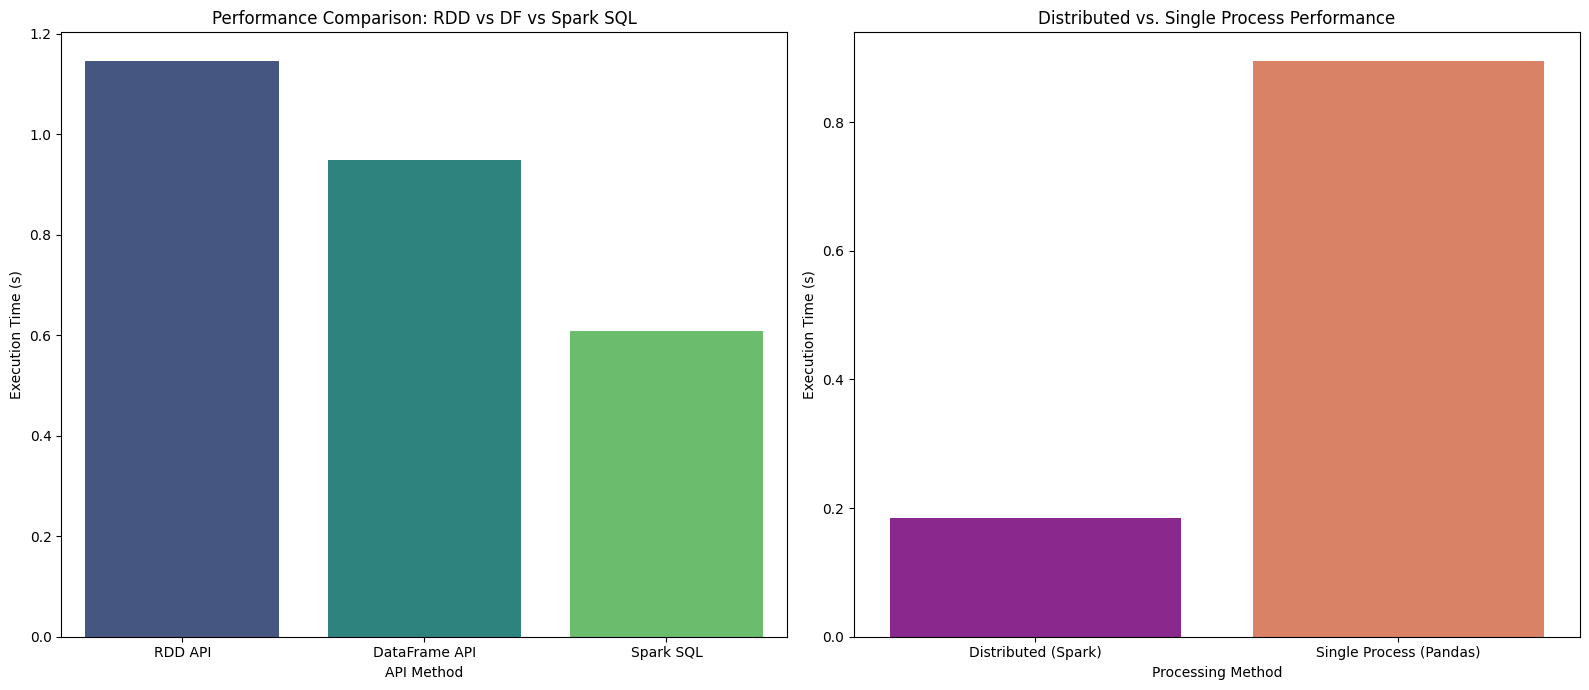

In [83]:
plt.figure(figsize=(16, 7))

# Plot 1: Final Performance Comparison Summary (RDD vs DF vs Spark SQL)
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.barplot(x='Method', y='Time (s)', data=performance_summary.sort_values(by='Time (s)', ascending=False), palette='viridis', hue='Method', legend=False)
plt.title('Performance Comparison: RDD vs DF vs Spark SQL')
plt.ylabel('Execution Time (s)')
plt.xlabel('API Method')

# Plot 2: Distributed vs. Single Process Performance
# Create a DataFrame for Distributed vs Single Process comparison
dist_single_comparison_df = pd.DataFrame({
    'Method': ['Distributed (Spark)', 'Single Process (Pandas)'],
    'Time (s)': [dist_time, single_time]
})

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.barplot(x='Method', y='Time (s)', data=dist_single_comparison_df, palette='plasma', hue='Method', legend=False)
plt.title('Distributed vs. Single Process Performance')
plt.ylabel('Execution Time (s)')
plt.xlabel('Processing Method')

plt.tight_layout()
plt.show()

In [84]:

# Stop Spark Session
# spark.stop() # Commented out to allow subsequent Spark operations
print(f"\nTotal script execution time: {time.time() - start_time:.2f} seconds.")
# print("Spark Session stopped.")


Total script execution time: 2072.96 seconds.
